<a href="https://colab.research.google.com/github/miki998/styleSpaceGan3-pytorch/blob/master/invert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/NVlabs/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd ./drive/MyDrive/LELSD/notebooks/

/content/drive/MyDrive/LELSD/notebooks


In [3]:
# !pip install boto3 botocore awscli --ignore-installed
# !pip install ninja
# !pip install torch==1.9.0
# !pip install torchvision==0.10.0

In [14]:
import os
import copy
from copy import deepcopy


import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import cv2
import torch
import torch.nn.functional as F


import sys
sys.path.append("../")
import models
from lelsd import LELSD

from utils.stylegan2_utils import StyleGAN2SampleGenerator
from utils.stylegan3_utils import StyleGAN3SampleGenerator
from utils.segmentation_utils import FaceSegmentation
from spaceUtils import * 



# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './stylegan2-ada-pytorch')

import dnnlib
import legacy

In [20]:
def load_pretrained_model(model_name, dataset_name):
    if model_name != "biggan":
        G = models.get_model(model_name,
                             f"../pretrained/{model_name}/{model2available_dataset[model_name][dataset_name]}")
    else:
        G = models.get_model(model_name, model2available_dataset[model_name][dataset_name])
    return G

def run_alignment(image_path):
    import dlib
    from scripts.align_faces_parallel import align_face
    if not os.path.exists("shape_predictor_68_face_landmarks.dat"):
        print('Downloading files for aligning face image...')
        os.system('wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')
        os.system('bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2')
        print('Done.')
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor) 
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image 
    
        
def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):
    
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)
    torch.manual_seed(100)
    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

In [9]:
model2available_dataset = {
    "stylegan2": {
        "FFHQ": "ffhq.pkl"
    },
    "stylegan3": {
        "FFHQ": "stylegan3-t-ffhq-1024x1024.pkl"
    }
}

dataset_name   = 'FFHQ'
truncation_psi = 0.7

In [16]:
device = torch.device('cuda')
G2     = load_pretrained_model('stylegan2', dataset_name)
SG2    = StyleGAN2SampleGenerator(G=G2, device=device, truncation_psi=truncation_psi)

G3     = load_pretrained_model('stylegan3', dataset_name)
SG3    = StyleGAN3SampleGenerator(G=G3, device=device, truncation_psi=truncation_psi)

In [11]:
aligned = run_alignment('../images/croppedMichael.jpg')
img     = cv2.resize(np.array(aligned),(1024,1024))
target  = torch.tensor(img.transpose([2, 0, 1]), device=device)

Aligned image has shape: (256, 256)


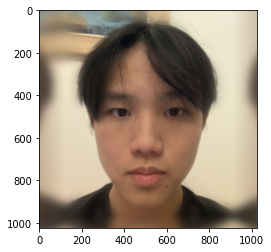

In [12]:
plt.imshow(img)

In [21]:
inv = project(G3, target=target, device=device)
torch.save(inv.cpu(),'../images/invertedMichael.pt')

In [31]:
gen       = SG3.generate_batch_from_ws(inv[110][None].cuda(), return_image=True) # the choice of which iteratively (in the process) inverted image is done manually
styleCode = gen['s']
original  = np.array(gen['image'][0])

Text(0.5, 1.0, '212_6 : +60')

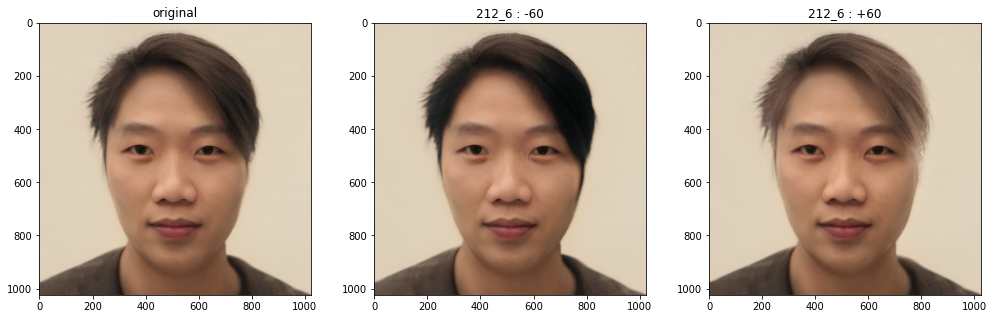

In [32]:
# hair
tmp1    = edit_image_stylegan3(SG3, styleCode, -60, 109, 8)
tmp2    = edit_image_stylegan3(SG3, styleCode, 60, 109, 8)
fig, ax = plt.subplots(1,3, figsize=(17,5))

ax[0].imshow(original)
ax[1].imshow(np.array(tmp1))
ax[2].imshow(np.array(tmp2))
ax[0].set_title('original')
ax[1].set_title('212_6 : -60')
ax[2].set_title('212_6 : +60')

Text(0.5, 1.0, '30_4 : +50')

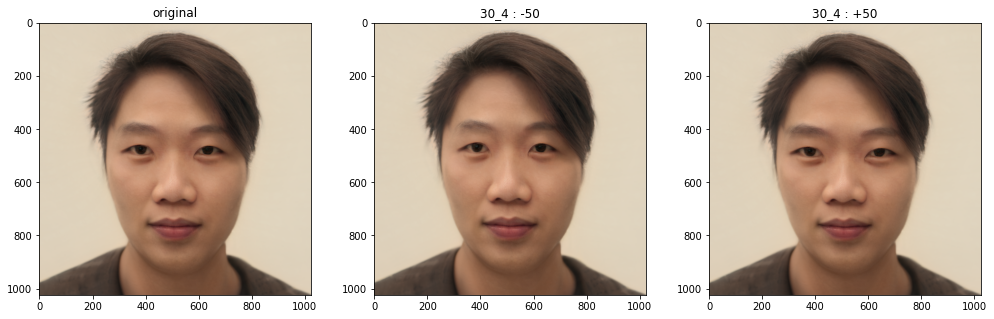

In [33]:
# eyes
tmp1    = edit_image_stylegan3(SG3, styleCode, -50, 30, 4)
tmp2    = edit_image_stylegan3(SG3, styleCode, 50, 30, 4)
fig, ax = plt.subplots(1,3, figsize=(17,5))

ax[0].imshow(original)
ax[1].imshow(np.array(tmp1))
ax[2].imshow(np.array(tmp2))
ax[0].set_title('original')
ax[1].set_title('30_4 : -50')
ax[2].set_title('30_4 : +50')

Text(0.5, 1.0, '328_6 : +30')

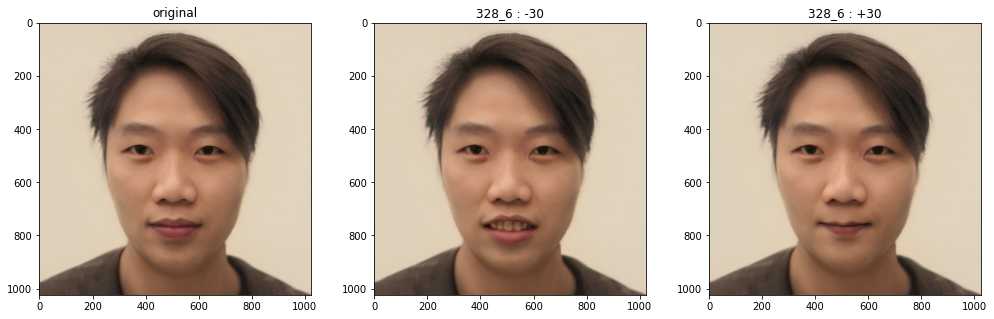

In [34]:
# mouth
tmp1    = edit_image_stylegan3(SG3, styleCode, -30, 328, 6)
tmp2    = edit_image_stylegan3(SG3, styleCode, 30, 328, 6)
fig, ax = plt.subplots(1,3, figsize=(17,5))

ax[0].imshow(original)
ax[1].imshow(np.array(tmp1))
ax[2].imshow(np.array(tmp2))
ax[0].set_title('original')
ax[1].set_title('328_6 : -30')
ax[2].set_title('328_6 : +30')

Remark:
- The inversion for some faces remain inaccurate but also could reach pretty high similarity when tailoring the originally taken picture (if carefully taken)
- Post-inversion, the latent code obtained still allow for decent edits and the channels found for SG3T still works for these real inverted images.